In [1]:
from itertools import combinations

from statsmodels.sandbox.stats.multicomp import multipletests 
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('churn_analysis.csv')

* state — штат США
* account_length — длительность использования аккаунта
* area_code — деление пользователей на псевдорегионы, использующееся в телекоме
* intl_plan — подключена ли у пользователя услуга международного общения
* vmail_plan — подключена ли у пользователя услуга голосовых сообщений
* vmail_message — количество голосых сообщений, который пользователь отправил / принял
* day_calls — сколько пользователь совершил дневных звонков
* day_mins — сколько пользователь проговорил минут в течение дня
* day_charge — сколько пользователь заплатил за свою дневную активность
* eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
* night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
* intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
* custserv_calls — сколько раз пользователь позвонил в службу поддержки
* treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
* mes_estim — оценка интенсивности пользования интернет мессенджерами
* churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [4]:
data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


### Задание 1
Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции scipy.stats.chi2_contingency(subtable, correction=False)

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем α=0.05?

In [5]:
# Для каждого штата посчитаем churn
state_churn = data[data.treatment == 1].pivot_table(index='churn', columns='state', aggfunc=len, fill_value=0)['area_code']
state_churn

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [6]:
# Создадим все комбинации пар штатов
state_pairs = list(combinations(data.state.unique(), 2))
len(state_pairs)

1275

In [7]:
# Создадим и заполним таблицы сопряженности
contingency_table = []
for pair in state_pairs:
    # Можно было сделать через np, но мне захотелось сохранить имена
    arr = [[state_churn[pair[0]]['True.'], state_churn[pair[0]]['False.']], 
           [state_churn[pair[1]]['True.'], state_churn[pair[1]]['False.']]]
    df = pd.DataFrame.from_records(data=arr, columns=['True', 'False'], index=pair)
    contingency_table.append(df)

In [8]:
# Отлично!
contingency_table[0]

,True,False
KS,7,18
OH,2,22


In [9]:
# Для каждой из таблиц применим критерий хи-квадрат
chi2_p_table = []
for index, subtable in enumerate(contingency_table): 
    p = stats.chi2_contingency(subtable, correction=False)[1]
    chi2_p_table.append((state_pairs[index], p))

In [10]:
len([x for x in chi2_p_table if x[1] < 0.05])

34

---

### Задание 2

Какие проблемы Вы видите в построении анализа из первого вопроса? Отметьте все верные утверждения.

* Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.

* Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез.

* Анализ нужно было начинать с применения xи-квадрат к таблице сопряженности, в которой присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов статистически значимо.

* Поправку на множественную проверку здесь применять нельзя — она используется только для группы критериев, проверяющих равенство средних (типа t-критерия). Критерий xи-квадрат не принадлежит этому семейству, поэтому поправка не нужна.

* Хи-квадрат используется для того, чтобы сравнить выборку с некоторым воздействием (treatment) и выборку без этого воздействия (control). Мы же в первом задании сравнивали штаты, используя данные только control группы. Для данных только из control группы использование xи-квадрат неправомерно.

Чтобы выбрать правильные варианты ответа нужно проверить каждое из утверждений:
- *"Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты."* - Одним из основных ограничений критерия хи-квадрат являются выборки с низкочастотными событиями. Если наблюдений < 40 и если ожидаемое значение меньше 5 больше чем в 20% ячейках. Посчитаем такие:



In [11]:
# Для каждой из таблиц посчитаем число наблюдений и наличие ожидаемого значения меньше 5
chi2_p_table_restriction = []
for index, subtable in enumerate(contingency_table): 
    less_obs_count = int(subtable.values.sum() < 40)            
    expected = stats.chi2_contingency(subtable, correction=False)[3]
    less_exp_val = int(expected.min() < 5) # так как у нас всего 4 ячейки, то наличие в одной - это уже 25%
    chi2_p_table_restriction.append((state_pairs[index], less_obs_count, less_exp_val))
    
chi2_p_table_restriction = np.array(chi2_p_table_restriction)
sum_less_40 = sum(chi2_p_table_restriction[:,1])
sum_less_5 = sum(chi2_p_table_restriction[:,2])

In [12]:
int((sum_less_40 / len(state_pairs)) * 100.0)

30

30% всех анализируемых таблиц содержит менее 40 наблюдений.

In [13]:
int((sum_less_5 / len(state_pairs)) * 100.0)

91

В 91% анализируемых таблиц ожидаемое значение меньше 5 больше чем в 20% ячеек.

Таким образом применение критерия ни к одной из таблиц нельзя считать обоснованным.

* *"Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты."* - **Верно**

* *"Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез."* - **Верно** http://www.machinelearning.ru/wiki/index.php?title=Множественная_проверка_гипотез

* *"Анализ нужно было начинать с применения xи-квадрат к таблице сопряженности, в которой присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов статистически значимо."* Нужно провести эксперимет, о котором говориться и сравнить значения

In [14]:
contingency_table_test = data[data.treatment == 1].pivot_table(index='churn', columns='state', aggfunc=len, fill_value=0)['area_code']

In [15]:
p_test = stats.chi2_contingency(np.array(contingency_table_test))[1]

In [16]:
p_test

0.70975900427784611

* *"Анализ нужно было начинать с применения xи-квадрат к таблице сопряженности, в которой присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов статистически значимо."* - **Верно**

* *"Поправку на множественную проверку здесь применять нельзя — она используется только для группы критериев, проверяющих равенство средних (типа t-критерия). Критерий xи-квадрат не принадлежит этому семейству, поэтому поправка не нужна."* - **Неверно**, на мой взгляд, множественная проверка не используется  только для группы критериев, проверяющих равнество средних.

* *Хи-квадрат используется для того, чтобы сравнить выборку с некоторым воздействием (treatment) и выборку без этого воздействия (control). Мы же в первом задании сравнивали штаты, используя данные только control группы. Для данных только из control группы использование xи-квадрат неправомерно.* - **Неверно**, само утверждение, крайне странное.

**Error:** только 0.8 из 1

---

### Задание 3

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного Oi и ожидаемого Ei значений, то есть, статистика с такой поправкой выглядит так:
$χ2Yates=∑i=1N(|Oi−Ei|−0.5)2Ei.$
Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией



In [17]:
# Для каждой из таблиц применим критерий хи-квадрат с поправкой
chi2_p_table_corrected = []
for index, subtable in enumerate(contingency_table): 
    p = stats.chi2_contingency(subtable, correction=True)[1]
    chi2_p_table_corrected.append((state_pairs[index], p))

In [18]:
len([x for x in chi2_p_table_corrected if x[1] < 0.05])

0

* *"Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05."* - **Верно**

* *"Количество достигаемых уровней значимости, меньших, чем 0.05, почти не изменилось, нельзя сказать, что введенная поправка сильно поменяла достигаемые уровни значимости."* - **Неверно**

In [19]:
diff_p = np.array(chi2_p_table_corrected)[0:,1] - np.array(chi2_p_table)[0:,1]

In [20]:
len([x for x in diff_p if x < 0])

192

* *"Поправка Йетса на непрерывность всегда увеличивает значение достигаемого уровня значимости, поэтому все получившиеся значения достигаемого уровня значимости строго больше или равны таковым значениям при отсутствии этой поправки."* - **Неверно**

In [21]:
np.mean(np.array(chi2_p_table_corrected)[0:,1]) - np.mean(np.array(chi2_p_table)[0:,1])

0.16222925833118851

* *"Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки."* - **Верно**

---

### Задание 4

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

In [22]:
# Для каждой из таблиц применим критерий Фишера
chi2_p_table_fisher = []
for index, subtable in enumerate(contingency_table): 
    p = stats.fisher_exact(subtable)[1]
    chi2_p_table_fisher.append((state_pairs[index], p))

* *"Точный критерий Фишера точно также, как и критерий xи-квадрат, нельзя использовать, если наблюдений < 40 и если ожидаемое значение меньше 5 больше чем в 20% ячейках."* - **Неверно** - по определению

* *"Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля."* - **Верно**, если я правильно понимаю материал

In [23]:
np.mean(np.array(chi2_p_table_fisher)[0:,1]) - np.mean(np.array(chi2_p_table)[0:,1])

0.14651092612815175

* *"Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат без поправки."* - **Неверно**, только на двух таблицах мы получили значение достигаемого уровня значимости по критерию Фишера меньше чем хи-квадрат

* *"Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки."* - **Верно**

In [24]:
np.mean(np.array(chi2_p_table_fisher)[0:,1]) - np.mean(np.array(chi2_p_table_corrected)[0:,1])

-0.015718332203036756

* *"Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса"* - **Верно**

---

### Задание 5

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [25]:
corr, p = stats.pearsonr(data[['day_calls']], data[['mes_estim']])
corr, p

(array([-0.05179435]), array([ 0.00277988]))

* *"Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо."* - **Верно**

---

### Задание 6

In [26]:
corr, p = stats.spearmanr(data[['day_calls']], data[['mes_estim']])
corr, p

(0.043349880533927444, 0.012317367189170541)

* *"Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо."* - **Верно**

---

### Задание 7

Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

* Не стоит ориентироваться на значение корреляции Спирмена, потому что корреляцию Спирмена можно считать только тогда, когда оба признака дискретные и между значениями можно установить строгий порядок. - **Неверно**

* Предположение нормальности данных двух признаков не выполнено, что хорошо видно на ку-ку графике, поэтому корреляция Пирсона может быть полностью неадекватна. - **Неверно**

* Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам. **Верно**

* Подсчет корреляций не имеет особого смысла, поскольку корреляция ничего не говорит о том, какая на самом деле зависимость имеется между признаками. **Неверно**

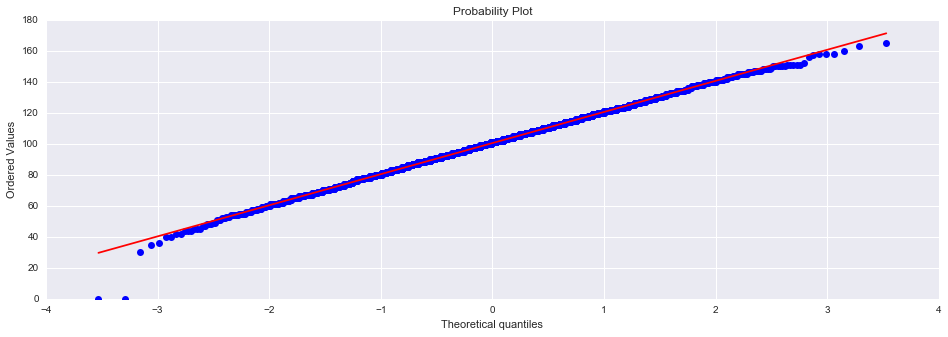

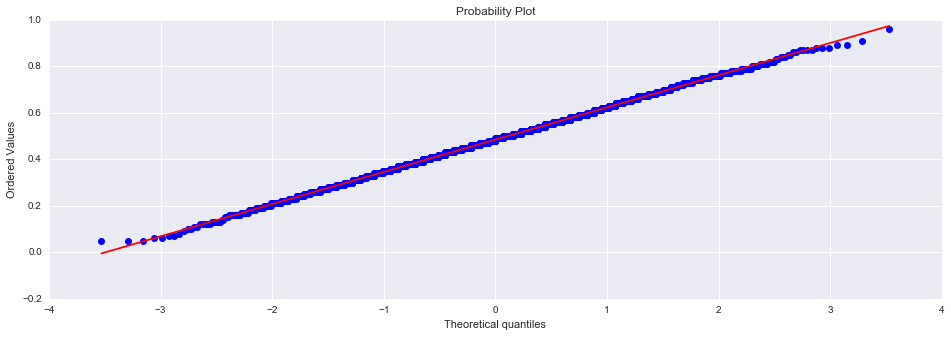

In [27]:
pylab.figure(figsize(16, 5))
stats.probplot(data['day_calls'].values, dist="norm", plot=pylab)
pylab.show()

pylab.figure(figsize(16, 5))
stats.probplot(data['mes_estim'].values, dist="norm", plot=pylab)
pylab.show()

---

### Задание 8

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [28]:
state_churn = data[data.treatment == 1].pivot_table(index='churn', columns='state', aggfunc=len, fill_value=0)['area_code']

In [29]:
chi2, p, dof, expected = stats.chi2_contingency(np.array(state_churn))

In [30]:
cramer = np.sqrt(chi2 / ((state_churn.sum().sum()) * (min(state_churn.shape)-1)))

In [31]:
p, cramer

(0.70975900427784611, 0.20039321502033319)

* *"Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо."* - **Верно**

* *"Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным."* - **Верно**

**Error:** что-то тут я сделал не так - 0 баллов.

---

### Задание 9
Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

*Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !*

* Чтобы выполнить данное задание, сначала нужно выбрать статистический критерий, по которому будем оценивать эффективность churn. Так как сравнивать следует доли и churn принимает только два значения (0 и 1), то будем использовать **Z-критерий для разности долей двух независимых выборок**. В качестве выборок возьмем пары методов (treatment)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1},  \hat{p}_2 = \frac{b}{n_2}$$ 

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [32]:
def proportions_diff_z_test(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
    
    return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

In [33]:
treatment0_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 0].churn.values]
treatment1_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 1].churn.values]
treatment2_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 2].churn.values]

In [34]:
p0_1 = proportions_diff_z_test(treatment0_churn, treatment1_churn)
p0_1

0.22833116390451069

In [35]:
p2_1 = proportions_diff_z_test(treatment2_churn, treatment1_churn)
p2_1

0.0093480842944511089

In [36]:
p2_0 = proportions_diff_z_test(treatment2_churn, treatment0_churn)
p2_0

0.15642468860508019

Теперь добавим поправку на множественную проверку с помощью **метода Холма**

In [37]:
reject, p_corrected, a1, a2 = multipletests([p0_1, p2_1, p2_0], alpha = 0.05, method = 'holm') 

In [38]:
reject, p_corrected

(array([False,  True, False], dtype=bool),
 array([ 0.31284938,  0.02804425,  0.31284938]))

* *"treatment = 2 статистически значимо отличается от контрольной группы treatment = 1"* - **Верно**
* *"Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо."* - **Верно**